# Spark minimal test

## Find Spark and create contexts

In [1]:
import os
import sys #current as of 9/26/2015

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print(sc)
print(sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

## Implementation plan

In [2]:
rdd = sc.parallelize(["#epicfail",  "#hadoop", "#rstats",  "#rstudio", "#rstats", "#spark", "#hadoop", "#hdfs",
"#hadoop",  "#oreilly", "#spark", "#python", "#spark", "#scala", "#spark", "#strataconf", "#strataconf", "#oreilly",
"#spark", "#databricks", "#hadoop", "#hdfs", "#spark",  "#hdfs"], 4)

rdd_distinct = rdd.distinct()
print(rdd_distinct.toDebugString().decode("utf8"))
for v in rdd_distinct.collect():
    print(v)

(4) PythonRDD[5] at RDD at PythonRDD.scala:43 []
 |  MapPartitionsRDD[4] at mapPartitions at PythonRDD.scala:374 []
 |  ShuffledRDD[3] at partitionBy at NativeMethodAccessorImpl.java:-2 []
 +-(4) PairwiseRDD[2] at distinct at <ipython-input-2-7c4889c0b393>:5 []
    |  PythonRDD[1] at distinct at <ipython-input-2-7c4889c0b393>:5 []
    |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:423 []
#hdfs
#oreilly
#databricks
#spark
#scala
#rstudio
#strataconf
#python
#hadoop
#epicfail
#rstats


# Data For this Quiz

There is a folder of data here:
https://www.dropbox.com/sh/vfq5el05b6mczf7/AAD4ETesjrflyeknMmX_engJa?dl=0

Notice the HASHSide Join below!

In [28]:
## Spark Application - execute with spark-submit

## Imports
import csv
import matplotlib.pyplot as plt

from io import StringIO
from datetime import datetime
from collections import namedtuple
from operator import add, itemgetter
from pyspark import SparkConf, SparkContext

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

## Module Constants
APP_NAME = "Flight Delay Analysis"
DATE_FMT = "%Y-%m-%d"
TIME_FMT = "%H%M"

fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields)

## Closure Functions
def parse(row):
    """
    Parses a row and returns a named tuple.
    """

    row[0]  = datetime.strptime(row[0], DATE_FMT).date()
    row[5]  = datetime.strptime(row[5], TIME_FMT).time()
    row[6]  = float(row[6])
    row[7]  = datetime.strptime(row[7], TIME_FMT).time()
    row[8]  = float(row[8])
    row[9]  = float(row[9])
    row[10] = float(row[10])
    return Flight(*row[:11])

def split(line):
    """
    Operator function for splitting a line with csv module
    """
    reader = csv.reader(StringIO(line))
    return reader.__next__() 

def plot(delays):
    """
    Show a bar chart of the total delay per airline
    """
    airlines = [d[0] for d in delays]
    minutes  = [d[1] for d in delays]
    index    = list(range(len(airlines)))

    fig, axe = plt.subplots()
    bars = axe.barh(index, minutes)

    # Add the total minutes to the right
    for idx, air, min in zip(index, airlines, minutes):
        if min > 0:
            bars[idx].set_color('#d9230f')
            axe.annotate(" %0.0f min" % min, xy=(min+1, idx+0.5), va='center')
        else:
            bars[idx].set_color('#469408')
            axe.annotate(" %0.0f min" % min, xy=(10, idx+0.5), va='center')

    # Set the ticks
    ticks = plt.yticks([idx+ 0.5 for idx in index], airlines)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))

    #minimize chartjunk
    plt.grid(axis = 'x', color ='white', linestyle='-')

    plt.title('Total Minutes Delayed per Airline')
    plt.show()

## Main functionality
def mainDriver(sc):

    # Load the airlines lookup dictionary
    airlines = dict(sc.textFile("data/ontime/airlines.csv").map(split).collect())

    # Broadcast the lookup dictionary to the cluster
    airline_lookup = sc.broadcast(airlines)

    # Read the CSV Data into an RDD
    flights = sc.textFille("data/ontime/flights.csv").map(split).map(parse)

    # Map the total delay to the airline (joined using the broadcast value)
    delays  = flights.map(lambda f: (airline_lookup.value[f.airline],
                                     add(f.dep_delay, f.arv_delay)))

    # Reduce the total delay for the month to the airline
    delays  = delays.reduceByKey(add).collect()
    delays  = sorted(delays, key=itemgetter(1))

    # Provide output from the driver
    for d in delays:
        print("%0.0f minutes delayed\t%s" % (d[1], d[0]))

    # Show a bar chart of the delays
    plot(delays)

#if __name__ == "__main__":
    # Configure Spark
#    conf = SparkConf().setMaster("local[*]")
#    conf = conf.setAppName(APP_NAME)
#    sc   = SparkContext(conf=conf)

    # Execute Main functionality
#    main(sc)

In [29]:
# Load the airlines lookup dictionary
airlines = dict(sc.textFile("ontime/airlines.csv").map(split).collect())

airlines

{'20199': 'Farwest Airlines: FRW',
 '19339': 'Trans East International: STF',
 '19374': 'Western Star Airlines Inc.: WES',
 '19414': 'Falcon Airways Inc.: FAC',
 '20412': 'Nations Air Express Inc.: N5 (1)',
 '20242': 'North Vancouver Air: NXQ',
 '20361': 'Valley Air Express Inc.: 2U',
 '21477': 'Charter Air Transport, Inc.: 1AQ',
 '19259': 'Nor East Commuter Airlines: NEC',
 '20435': 'Frontier Airlines Inc. (1): FL (1)',
 '19171': 'Decatur Aviation: DEC',
 '20310': 'Caribbean Sun Airlines, Inc. d/b/a World Atlantic Airlines: K8',
 '20257': 'Bemidji Airlines: CH',
 '20449': 'Aero-Services-Corporate: WEQ',
 '19321': 'Sfo Helicopter Airlines Inc.: SFO',
 '19514': 'Aeronaves Del Peru: ADQ',
 '19122': 'Business Aircraft Corp.: BAC',
 '19190': 'Young Flying Service: FBI',
 '20368': 'Allegiant Air: G4',
 '21236': 'Vision Airlines: 0JQ',
 '21598': 'WOW Air ehf: WW',
 '20021': 'Eagle Airlines (1): ECA',
 '19650': 'Air Sunshine Inc.: AAT',
 '19518': 'Lufthansa Cargo Airlines: GE',
 '19715': 'Wes

-45442 minutes delayed	Alaska Airlines Inc.: AS
-20654 minutes delayed	Hawaiian Airlines Inc.: HA
39247 minutes delayed	AirTran Airways Corporation: FL
40841 minutes delayed	Virgin America: VX
108480 minutes delayed	Frontier Airlines Inc.: F9
177717 minutes delayed	US Airways Inc.: US
279981 minutes delayed	JetBlue Airways: B6
390614 minutes delayed	United Air Lines Inc.: UA
431755 minutes delayed	American Airlines Inc.: AA
461753 minutes delayed	Delta Air Lines Inc.: DL
493527 minutes delayed	Envoy Air: MQ
519867 minutes delayed	SkyWest Airlines Inc.: OO
1160058 minutes delayed	ExpressJet Airlines Inc.: EV
2181955 minutes delayed	Southwest Airlines Co.: WN


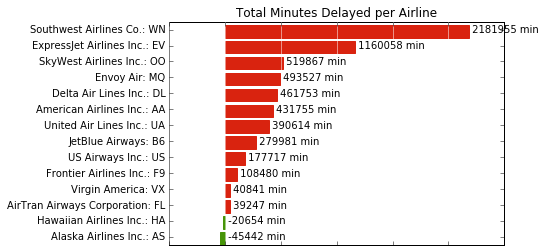

In [30]:
# Broadcast the lookup dictionary to the cluster
airline_lookup = sc.broadcast(airlines)

# Read the CSV Data into an RDD
flights = sc.textFile("ontime/flights.csv").map(split).map(parse)

# Map the total delay to the airline (joined using the broadcast value)
# Hashside join here!
delays  = flights.map(lambda f: (airline_lookup.value[f.airline],
                                 add(f.dep_delay, f.arv_delay)))

# Reduce the total delay for the month to the airline
delays  = delays.reduceByKey(add).collect()
delays  = sorted(delays, key=itemgetter(1))

# Provide output from the driver
for d in delays:
    print("%0.0f minutes delayed\t%s" % (d[1], d[0]))

# Show a bar chart of the delays
plot(delays)


# Quiz: EDA: For soutwest compute the average delay

In [7]:
# For soutwest compute the average delay